In [11]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

import dataset_loader

%matplotlib inline

In [12]:
# Download mnist dataset from another place than in lab 1 (that one does not work anymore)
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"

mnist_path = "./mnist.pkl.gz"

(train_data_pixels, train_data_classes), (dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [13]:
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [14]:
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


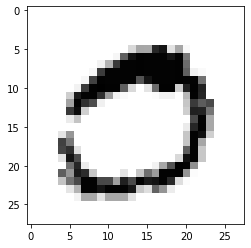

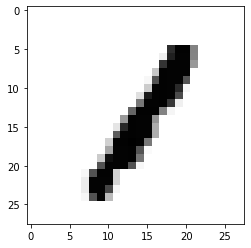

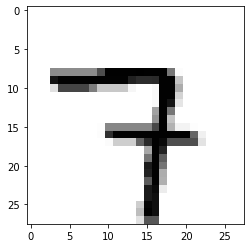

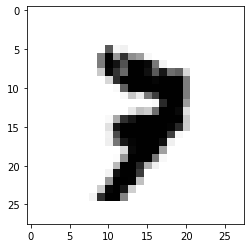

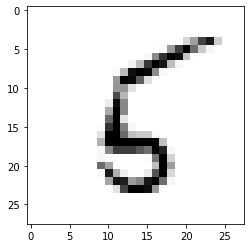

In [15]:
def display_images(images):
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
display_images(train_data_pixels[:5])

In [16]:
def KL_with_gaussian_prior(mu, log_sigma_squared):
    return - .5 * torch.sum(1 + log_sigma_squared - mu**2 - torch.exp(log_sigma_squared), 1)

In [17]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mean_out = nn.Linear(hidden_dim, output_dim)
        self.logvar_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.fc1(batch)
        act = F.relu(hid)
        mean = self.mean_out(act)
        logvar = self.logvar_out(act)
        
        return (mean, logvar)

In [28]:
from torch.distributions.multivariate_normal import MultivariateNormal

    
def sample_prior(n_features, n_samples=1):
    return MultivariateNormal(torch.zeros(n_features), torch.eye(n_features)).sample((n_samples,))

class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mean_out = nn.Linear(hidden_dim, output_dim)
        self.input_dim = input_dim
        
       
    def forward(self, batch):
        hid = self.fc1(batch)
        act = F.relu(hid)
        
        return F.sigmoid(self.mean_out(act))
    
    def sample_distributions(self, n_samples):
        z = sample_prior(self.input_dim, n_samples)
        return self(z)

In [29]:
def sample_images(decoder, n_samples, argmax=False):
    means = decoder.sample_distributions(n_samples)

    if argmax:
        return means
    else:
        var = 0.1**2
        x = means + var * torch.randn_like(means)
        return x

In [53]:
dim_input = 28*28
latent_dim = 2
hidden_dim = 400
n_epoch = 50
batch_dim = 256

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)

# we must pass both network parameters to the optimizer
# sometime its also useful to use two different optimizers,
# for example if we want to use different learning rates.
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim]
        mu, log_sigma_squared = encoder(batch)
        

        eyes = torch.diag_embed(torch.ones_like(log_sigma_squared))
        epsilon = MultivariateNormal(torch.zeros_like(mu), eyes).sample()
        z = mu + epsilon*torch.exp(log_sigma_squared)
        
        reconstruction_logits = decoder(z)
        reconstruction_loss = F.mse_loss(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)

        elbo = -reconstruction_loss.sum(1) - kl_div
        
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        loss = -elbo.mean()
        loss.backward()
        

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0]
    )

0 :	 -49.27761875488281 	 2.3422165461301803
1 :	 -39.36580031738281 	 2.0657892111206055
2 :	 -37.91203889160156 	 2.1764256393432615
3 :	 -36.94027309082031 	 2.262620719604492
4 :	 -36.18516841796875 	 2.3258805276489256
5 :	 -35.62714685546875 	 2.3818034326171875
6 :	 -35.20422778320312 	 2.416085704345703
7 :	 -34.8301301171875 	 2.4487712997436524
8 :	 -34.5329405859375 	 2.4722673794555665
9 :	 -34.2683320703125 	 2.4917241369628904
10 :	 -34.030388515625 	 2.5179903289794923
11 :	 -33.830955375976565 	 2.538643583984375
12 :	 -33.658447119140625 	 2.546474142456055
13 :	 -33.482192109375 	 2.5641811358642577
14 :	 -33.35307916015625 	 2.572937738647461
15 :	 -33.20923997070312 	 2.582312440185547
16 :	 -33.08535216796875 	 2.598399351196289
17 :	 -32.97628973632813 	 2.608238024902344
18 :	 -32.88371067871094 	 2.610443001098633
19 :	 -32.785697509765626 	 2.629058502807617
20 :	 -32.69943245605469 	 2.632534481201172
21 :	 -32.609553466796875 	 2.6387870315551756
22 :	 -32.53

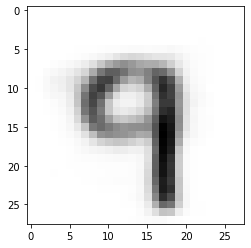

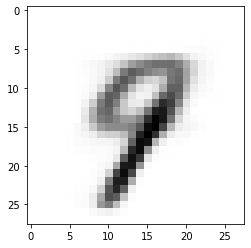

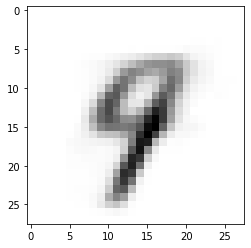

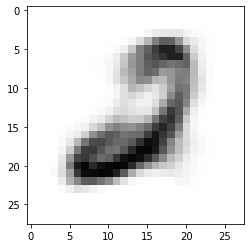

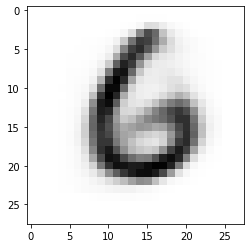

In [54]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = sample_images(decoder, 5, argmax=True)
    display_images(samples)

tensor([[-1.0244,  0.6154],
        [-0.8284,  0.6925],
        [-0.6324,  0.7696],
        [-0.4363,  0.8467],
        [-0.2403,  0.9238],
        [-0.0443,  1.0009],
        [ 0.1518,  1.0780],
        [ 0.3478,  1.1551],
        [ 0.5438,  1.2322],
        [ 0.7398,  1.3094],
        [ 0.9359,  1.3865]], grad_fn=<AddBackward0>)


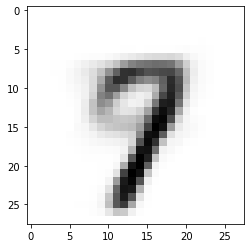

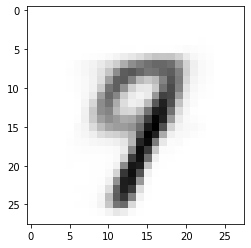

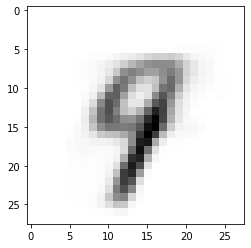

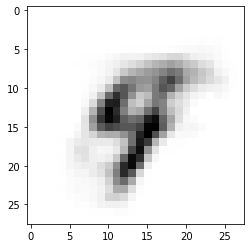

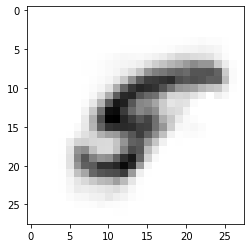

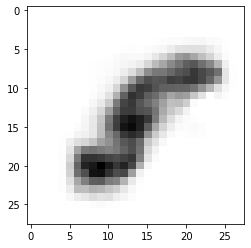

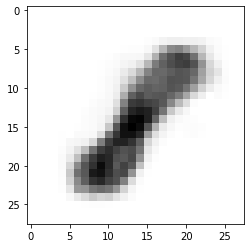

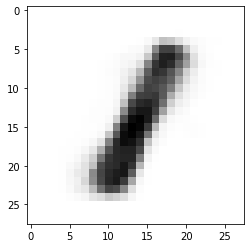

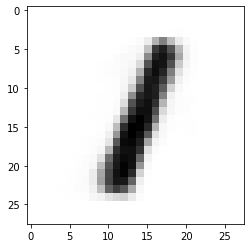

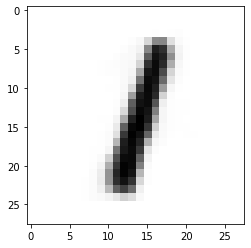

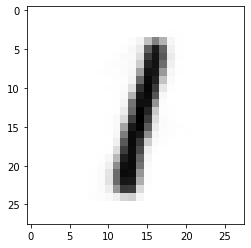

In [55]:
def get_mean(encoder, x_data, y_data, num = 0):
    class_data = x_data[y_data == num]
    
    encoder.eval()
    mu, _ = encoder(class_data)
    
    return torch.mean(mu, axis=0)
    

mean_num1 = get_mean(encoder, train_data_pixels, train_data_classes, num=1)
mean_num2 = get_mean(encoder, train_data_pixels, train_data_classes, num=7)

# end=1.1 as the end in the included in the range
epsilon = torch.arange(0, 1.1, 0.1)
latent_values = epsilon.reshape(-1, 1) * mean_num1 + (1 - epsilon.reshape(-1, 1)) * mean_num2


print(latent_values)
decoder.eval()

with torch.no_grad():
    means = decoder(latent_values)
    display_images(means)

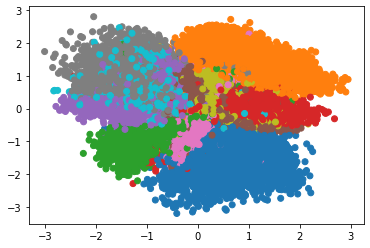

In [56]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu, _ = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()[:,:2]

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.show()